In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_origin = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [3]:
df = df_origin[df_origin.Site_Name=='The Masada']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [4]:
dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfLastYearVisits = df.dropna()

In [5]:
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(1011, 8)
(1011, 7)


In [6]:
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2

In [7]:
dfLastYearVisits.sort_values('Date')
X = dfLastYearVisits.drop(['Israelis_Count'],axis=1)
y = dfLastYearVisits[['Date','Israelis_Count']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
 
X_train_scaled


X_train_date = X_train.Date
y_train_date = y_train.Date
X_test_date = X_test.Date
y_test_date = y_test.Date

y_train.drop('Date',axis=1,inplace=True)
y_test.drop('Date',axis=1,inplace=True)

In [30]:
# create NN model
model = Sequential()
model.add(Dense(X_train_scaled.shape[1], input_dim=X_train_scaled.shape[1],activation='relu',activity_regularizer=l2(0.01)))
model.add(Dense(516,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
 

In [31]:
# Compiling the model
model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1 )
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=0 )
mcp = ModelCheckpoint(filepath='weightsTheMasada.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=10000,callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=1)
clear_output(True)


Epoch 1/10000
618/646 [===========================>..] - ETA: 0s - loss: 1226088.1250 - mae: 869.9850 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 793558.75000, saving model to weightsTheMasada.h5
646/646 [==============================] - 2s 2ms/step - loss: 1202667.0000 - mae: 859.5339 - accuracy: 0.0000e+00 - val_loss: 793558.7500 - val_mae: 699.4926 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10000
646/646 [==============================] - ETA: 0s - loss: 530501.3750 - mae: 569.0233 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 793558.75000
646/646 [==============================] - 1s 2ms/step - loss: 530501.3750 - mae: 569.0233 - accuracy: 0.0000e+00 - val_loss: 828417.3750 - val_mae: 718.7067 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10000
641/646 [============================>.] - ETA: 0s - loss: 546257.0000 - mae: 572.7579 - accuracy: 0.0000e+00
Epoch 3: val_loss did not improve from 793558.75000
646/646 [============================

In [32]:
model.load_weights('weightsTheMasada.h5')

In [33]:
model.save('Model TheMasada')

INFO:tensorflow:Assets written to: Model TheMasada\assets


26/26 [==============================] - 0s 2ms/step

mae 527.970357233935
rmse 667.4085167217634
std 809.1665472718446


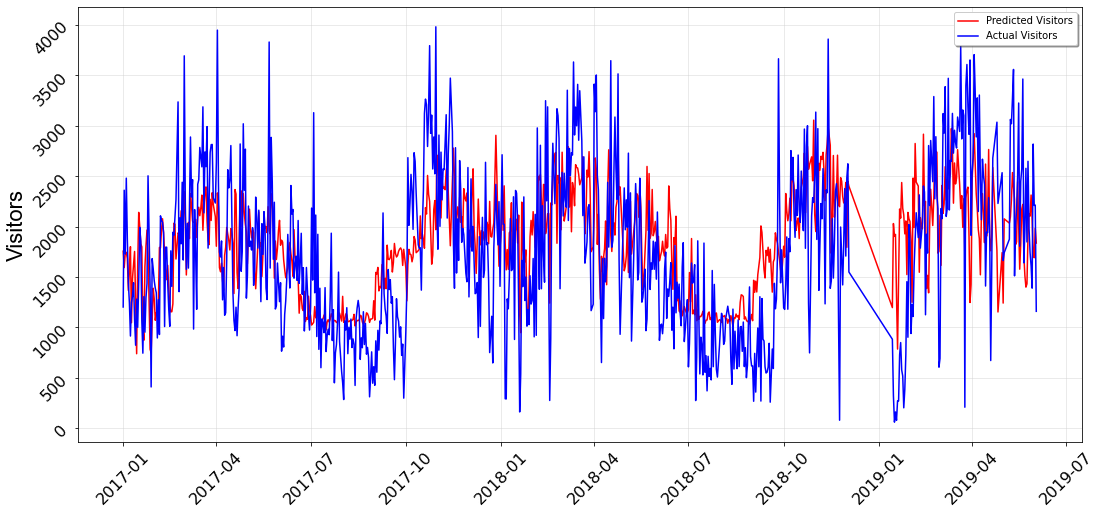

,Prediction,Actual
Date,,
2017-01-01,1756.088379,1203
2017-01-02,1593.486084,2361
2017-01-03,1737.498413,1729
2017-01-04,1745.722412,2481
2017-01-05,1684.295166,1878
2017-01-06,1367.339844,1442
2017-01-07,1555.283325,1245
2017-01-08,1800.981445,915
2017-01-09,1046.917114,1249


In [34]:
prediction = model.predict(X_train_scaled)
prediction = prediction.reshape(len(X_train_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_train.values.T[0],
        },
    index=y_train_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

7/7 [==============================] - 0s 1ms/step

mae 486.11466942397243
rmse 621.9546170114946
std 782.933047432456


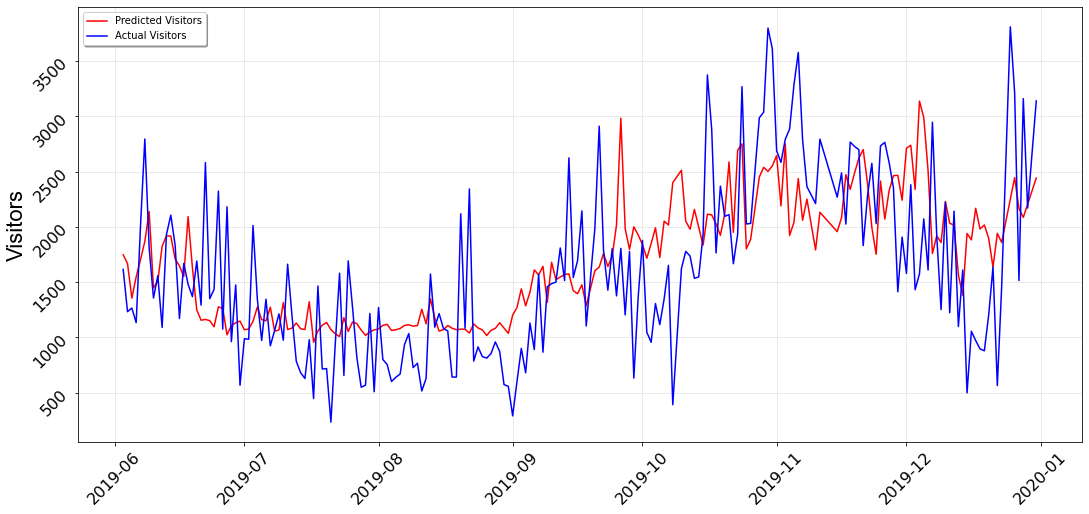

,Prediction,Actual
Date,,
2019-06-03,1747.238770,1615
2019-06-04,1667.551147,1232
2019-06-05,1354.895996,1265
2019-06-06,1546.740967,1133
2019-06-07,1703.374756,2004
2019-06-08,1867.965088,2795
2019-06-09,2138.948975,1810
2019-06-10,1447.366089,1356
2019-06-11,1505.086182,1558


In [35]:
prediction = model.predict(X_test_scaled)
prediction = prediction.reshape(len(X_test_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values.T[0],
        },
    index=y_test_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

In [36]:
from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train_scaled[:,x]))
    for x in range(X_train_scaled.shape[1])]) <= 2).flatten()

print(X_train_scaled.shape)
print(categorical_features.shape)
print(X_train_scaled.shape)

explainer = LimeTabularExplainerOvr(np.array(X_train_scaled),
 feature_names=X_train.drop('Date',axis=1).columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True,
 mode='regression'
 )

i = np.random.randint(len(X_test_scaled))
print('index ', i, ':: Actual values = ', y_test.Israelis_Count.values[i])
print('index ', i, ':: Prediction values = ', prediction.tolist()[i])
exp = explainer.explain_instance((X_test_scaled[i]),model.predict,num_features=100)
exp.show_in_notebook(show_table=True)
function.outputLimeAsDf(exp)


(808, 6)
(3,)
(808, 6)
index  150 :: Actual values =  2793
index  150 :: Prediction values =  2751.680908203125
157/157 [==============================] - 0s 2ms/step
Intercept 1313.647091718035
Prediction_local [2339.50444573]
Right: 2751.681


,0
last year visitors,536.982661
IsVacation,-401.849055
is weekend,-131.637240
pm10,-17.276055
IsHoliday,14.321664
Temperature,-13.013883
